In [739]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [740]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [741]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [742]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [743]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

C:\Users\David\AppData\Local\Temp\ipykernel_1924\1895431338.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [744]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [745]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [746]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [747]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [748]:
#test
#most_recent_date = most_recent_date[0]
#print(most_recent_date)

#most_recent_date= pd.to_datetime(most_recent_date)
#past_year = most_recent_date - pd.DateOffset(years=1)

#past_year = past_year.date()
#print(past_year)


#session.query(measurement.date,measurement.prcp).\
#    group_by(measurement.date).\
#    filter(measurement.date >= one_year_ago, measurement.date <= recent_date).all()


2017-08-23
2016-08-23


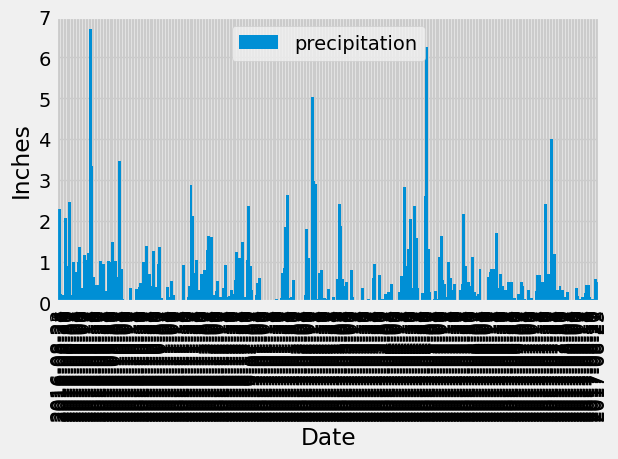

In [749]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = most_recent_date[0]
print(most_recent_date)

most_recent_date= pd.to_datetime(most_recent_date)
past_year = most_recent_date - pd.DateOffset(years=1)
most_recent_date = most_recent_date.date()
past_year = past_year.date()
print(past_year)

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= past_year, measurement.date <= most_recent_date).all()

date_prcp
# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prcp_df = pd.DataFrame(date_prcp, columns=['date', 'precipitation'])

# Sort the dataframe by date
date_prcp_df['date'] = pd.to_datetime(date_prcp_df['date'])
date_prcp_df = date_prcp_df.sort_values(by='date', ascending=True)
date_prcp_df['date'] = date_prcp_df['date'].dt.strftime('%Y-%m-%d')
#date_prcp_df.set_index('date', inplace=True)
totalprcp_df = date_prcp_df.groupby('date', as_index=False)['precipitation'].max()


# Use Pandas Plotting with Matplotlib to plot the data
totalprcp_df.plot(x='date', y='precipitation', kind='bar', width=2)
plt.style.use('fivethirtyeight')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.ylim(0, 7)
plt.grid(True)


In [750]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = date_prcp_df['precipitation'].describe()
prcp_stats = pd.DataFrame(prcp_stats)
prcp_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [751]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [752]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc()).all()
)
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [753]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
print(most_active_station_id)

most_active_station_id_temperatures = (
    session.query(
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)
    )
    .filter(measurement.station == most_active_station_id)
    .one()
)
most_active_station_id_temperatures

USC00519281


(54.0, 85.0, 71.66378066378067)

In [754]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs_last12months = session.query(
    measurement.date, measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= past_year , measurement.date <= most_recent_date).all()

most_active_station_tobs_last12months_df = pd.DataFrame(most_active_station_tobs_last12months, columns=['date', 'tobs'])
most_active_station_tobs_last12months_df.head()





,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


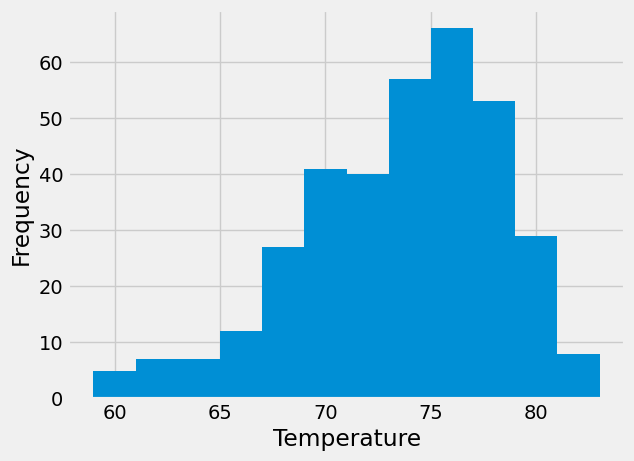

In [755]:
plt.hist(most_active_station_tobs_last12months_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [756]:
# Close Session
session.close()